# Coupled Oscillator Model parameter optimization with UKF on fMRI data

### Libraries

-   KernSmooth: Kernel smoothing on voxel data
-   deSolve: Solve ODEs
-   ggplot2: Plotting

UKF library functions are imported locally for modifications. Original functions are designed to work on optimization of 2 variables, we modified the function for the new model. Plotting functions are implemented with ggplot2.

In [1]:
library(KernSmooth)
library(deSolve)
library(ggplot2)
#library(devtools)
#install_github("insilico/UKF")  
# library(UKF)
#install.packages(c('KernSmooth'))

# hide warnings
options(warn=-1)

Warning message:
"package 'KernSmooth' was built under R version 4.2.3"
KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Warning message:
"package 'deSolve' was built under R version 4.2.3"
Warning message:
"package 'ggplot2' was built under R version 4.2.3"


## Unscented Kalman Filter - UKF

This code is taken from https://github.com/insilico/UKF/blob/main/R/UKF.R

We modifed the UKF_blend and iterative_param_optim functions to work with new model.

In [2]:
UKF_dT <- function(t_dummy,ode_model,xhat,Pxx,y,N_p,N_y,R,dt,dT){
    N_x <- N_p + N_y # number of augmented states
    N_sigma <- 2*N_x # number sigma points
    xsigma <- t(chol(N_x*Pxx, pivot=T))
    Xa <- xhat %*% matrix(rep(1,length=N_sigma),nrow=1,ncol=N_sigma) + cbind(xsigma,-xsigma)
    X <- propagate_model(t_dummy,ode_model,dt,dT,N_p,Xa)
    xtilde <- t(t(rowSums(X))/N_sigma)
    Pxx <- matrix(rep(0,length=N_x*N_x),nrow=N_x,ncol=N_x)
    for(i in 1:N_sigma){
      Pxx <- Pxx + ((X[,i] - xtilde) %*% t(X[,i] - xtilde))/N_sigma
    }
    Y <- X[(N_p+1):(N_p+N_y),]
    ytilde <- t(t(rowSums(Y))/N_sigma)
    Pyy <- R
    for(i in 1:N_sigma){
      Pyy <- Pyy + ((Y[,i] - ytilde) %*% t(Y[,i] - ytilde))/N_sigma
    }
    Pxy <- matrix(rep(0,length = N_x*N_y),nrow=N_x,ncol=N_y)
    for(i in 1:N_sigma){
      Pxy <- Pxy + ((X[,i] - xtilde) %*% t(Y[,i] - ytilde))/N_sigma
    }
    K <- Pxy %*% solve(Pyy)  # Kalman Gain Matrix
    xhat <- xtilde + K %*% (y - ytilde)
    Pxx <- Pxx - K %*% t(Pxy)

    return(list(xhat = xhat, Pxx = Pxx, K = K))
} # ENDFN UKF

propagate_model <- function(t,ode_model,dt,dT,N_p,x){
  nn <- round(dT/dt)
  p <- x[1:N_p,]  # grab parameters
  y <- x[(N_p+1):length(x[,1]),]  # grab ind vars
  # Runge-Kutta
  for(n in 1:nn){
    k1 <- dt*ode_model(t,y,p)
    k2 <- dt*ode_model(t,y + k1/2,p)
    k3 <- dt*ode_model(t,y + k2/2,p)
    k4 <- dt*ode_model(t,y + k3,p)
    y <- y + k1/6 + k2/ + k3/3 + k4/6
  }
  r <- rbind(x[(1:N_p),],y) # returns new augmented
  return(r)
} # ENDFN propagate_model

UKF_blend <- function(t_dummy,ts_data,ode_model,N_p,N_y,param_guess,dt,dT,R_scale=0.3,Q_scale=0.015){
  time_points <- ts_data[,1]
  num_time <- length(time_points)
  N_x <- N_p + N_y
  # Modified the length of xhat to be N_x*num_time instead of 4*num_time
  xhat <- matrix(rep(0,length=N_x*num_time),nrow=N_x,ncol=num_time)
  Pxx <- vector(mode = "list", length = num_time)
  for(i in 1:num_time){
    Pxx[[i]] <- matrix(rep(0,length=N_x*N_x),nrow=N_x,ncol=N_x)
  }
  # Modified the length of xhat to be N_x*num_time instead of 4*num_time
  errors <- matrix(rep(0,length=N_x*num_time), nrow=N_x,ncol=num_time)
  Ks <- vector(mode = "list", length = num_time)
  for(i in 1:num_time){
    Ks[[i]] <- matrix(rep(0,length=N_x*N_y),nrow=N_x,ncol=N_y)
  }
  z <- t(t(param_guess)) %*% matrix(rep(1,length=num_time),nrow=1,ncol=num_time)
  y0 <- t(ts_data[,-1])
  x <- rbind(z,y0) # stack
  xhat[,1] <- x[,1]  # right now xhat is all data
  R <- (R_scale)^2*cov(t(x[(N_p+1):(N_y+N_p),])) # only y
  Pxx[[1]] <- pracma::blkdiag(Q_scale*diag(N_p),R)
    set.seed(1)
    y <- x[(N_p+1):(N_y+N_p),] + (pracma::sqrtm(R)$B) %*%  # adding noise
      matrix(rnorm(2*num_time),nrow=2,ncol=num_time)
    UKF_kstep <- list(xhat = xhat[,1], Pxx = Pxx[[1]], K = Ks[[1]])
    for(k in 2:num_time){
      UKF_kstep <- tryCatch(
        {
          UKF_dT(t_dummy,ode_model,xhat[,k-1],Pxx[[k-1]],y[,k], N_p,N_y,R,dt,dT)
        },
        error=function(cond) {
          message("By chance, matrix caused Cholesky to fail.")
          message("Here's the original error message:")
          message(cond)
          message("Skipping this iteration.")
          return(UKF_kstep)
        }
      ) # end tryCatch
      xhat[,k] <- UKF_kstep$xhat
      Pxx[[k]] <- UKF_kstep$Pxx
      Ks[[k]] <- UKF_kstep$K
      errors[,k] <- sqrt(diag(Pxx[[k]]))
    } # end application of UKF blend to all time points
    param_estimated <- t(t(xhat[(1:N_p),num_time]))
  chisq <- 0
  for(i in 1:N_y){
    chisq <- chisq + (x[(N_p+i),] - xhat[(N_p+i),])^2
  }
  chisq <- mean(chisq)
  error <- t(errors[(1:N_p),num_time])

  return(list(param_est=param_estimated, xhat=xhat,error=error,chisq=chisq))
} # END FN UKF_blend

optim_params <- function(param_guess,method="L-BFGS-B",lower_lim,upper_lim,maxit,temp=20,
                    t_dummy,ts_data,ode_model,N_p,N_y,dt,dT){
  ukf_obj <- NULL  
  chisq_objective <- function(par_vec){
    ukf_obj <<- UKF_blend(t_dummy,ts_data, ode_model, N_p,N_y,par_vec,dt,dT)
    return(ukf_obj$chisq)
  }
  if (method=="SANN"){
    # simulated annealing
    opt <- optim(param_guess,chisq_objective,method="SANN",
               control = list(maxit = maxit, temp = temp))
  } else{
    # Broyden-Fletcher-Goldfarb-Shannon
    opt <- optim(param_guess,chisq_objective,method="L-BFGS-B",
                 lower=lower_lim,upper=upper_lim)
  }
  return(list(par=opt$par, value=opt$value, param_est=opt$par, xhat=ukf_obj$xhat))
}


iterative_param_optim <- function(param_guess, t_dummy,ts_data,ode_model, N_p,N_y,dt,dT, param_tol=.01,MAXSTEPS=30){
  done <- F
  steps <- 0
  while (!done){
    ukf_run <- UKF_blend(t_dummy,ts_data, ode_model, N_p,N_y,param_guess,dt,dT)
    param_new <- ukf_run$param_est      
    steps <- steps + 1
    param_norm <- abs(sum(param_new-param_guess))
    converged <- param_norm < param_tol
    done <- converged | steps >= MAXSTEPS
    }
  # Modified output varaiable par to param_est to match the UKF_blend output
  return(list(param_est=param_new,value=ukf_run$chisq, xhat=ukf_run$xhat, param_norm=param_norm,steps=steps))
}

## Kernel Smoothing and Plot

These functions are the modified versions of plot_voxels_and_smooth and plot_ukf_and_smoothed functions provided in https://github.com/insilico/UKF/blob/main/R/plot_and_smooth.R

We created the ggplot2 versions of these functions and modified the plot_voxels_and_smooth_ggplot to utilize plot_ukf_and_smoothed_ggplot function.

In [3]:
plot_ukf_and_smoothed_ggplot <- function(ukf_out, smoothed_data, top_title="UKF estimate and kernel smooth"){
  # Modification for the number of parameters, previously it was used as ukf_out$xhat[3,]
  n_p <- length(ukf_out$param_est) + 1
  # Create dataframes
  df1 <- data.frame(Time = 1:length(ukf_out$xhat[n_p,]), 
                    Value = c(ukf_out$xhat[n_p,], smoothed_data[,2]),
                    Type = rep(c("UKF", "Kernel"), each=length(ukf_out$xhat[n_p+1,])))
  df2 <- data.frame(Time = 1:length(ukf_out$xhat[n_p+1,]), 
                    Value = c(ukf_out$xhat[n_p+1,], smoothed_data[,3]),
                    Type = rep(c("UKF", "Kernel"), each=length(ukf_out$xhat[n_p+1,])))
  
  # Plot for Voxel A
  p1 <- ggplot(df1, aes(x = Time, y = Value, color = Type)) +
    geom_point(data = subset(df1, Type == "UKF")) +
    geom_line(data = subset(df1, Type == "Kernel")) +
    labs(title = top_title, y = "Voxel A") +
    theme_minimal() +
    scale_color_manual(values = c("red", "darkgrey"))
  
  param_title <- paste0("p", seq_along(ukf_out$param_est), " = ", round(ukf_out$param_est, digits=2), collapse=", ")
  # Plot for Voxel B
  p2 <- ggplot(df2, aes(x = Time, y = Value, color = Type)) +
    geom_point(data = subset(df2, Type == "UKF")) +
    geom_line(data = subset(df2, Type == "Kernel")) +
    labs(title = param_title, y = "Voxel B") +
    theme_minimal() +
    scale_color_manual(values = c("red", "darkgrey"))
  
  print(p1)
  print(p2)
}

In [4]:
plot_voxels_and_smooth_ggplot <- function(voxel_input){
  voxel_Time <- voxel_input[,1]
  voxel_data <- cbind(voxel_Time,voxel_input[,2], voxel_input[,3])
  voxel.df <- data.frame(times=voxel_data[,1], VoxA=voxel_data[,2], VoxB=voxel_data[,3])
  y1_obs <- voxel.df[,2]
  y2_obs <- voxel.df[,3]
  n <- length(t(voxel_Time))
  m_points <- seq(1,n,by=1)  
  h <- tryCatch( # kernel bandwidth using KernSmooth
    {dpill(m_points, y1_obs)},
    error=function(cond) {
      message("Install/load KernSmooth for better smoothing.")
      message(cond)
      message("Using default kernel bandwidth h=.5.")
      return(0.5)
    }
  ) # end tryCatch
  
  fit1 <- ksmooth(m_points, y1_obs, kernel="normal",bandwidth = h, n.points=176)
  h <- dpill(m_points, y2_obs)
  fit2 <- ksmooth(m_points, y2_obs, kernel="normal", bandwidth = h, n.points=176)
  y1_obs.processed <- fit1$y
  y2_obs.processed <- fit2$y

  ukf_out <- list(xhat = rbind(y1_obs.processed, y2_obs.processed, y1_obs, y2_obs), param_est = c(0, 0)) # revised ukf_out
  smoothed_data <- cbind(t(t(m_points)), t(t(y1_obs.processed)), t(t(y2_obs.processed)))

  plot_ukf_and_smoothed_ggplot(ukf_out, smoothed_data, top_title="Real data and kernel smooth")

  return(smoothed_data)
}

## New Coupled Oscillator Model - Two Coupled Pendulums

The equation of motion of the combined system
is then given by:
$$L \ddot{\theta}_{1} =-g \sin \theta_{1}-k L\left(\sin \theta_{1}-\sin \theta_{2}\right)$$
$$L \ddot{\theta}_{2} =-g \sin \theta_{2}+k L\left(\sin \theta_{1}-\sin \theta_{2}\right)$$

There are 3 parameters in the equation:
- g, gravity
- L, length of pendulums
- k, spring constant

without the assumption of pendulums having same length, $L_1$ and $L_2$ would replace the L in corresponding equation:
$$L_1 \ddot{\theta}_{1} =-g \sin \theta_{1}-k L_1\left(\sin \theta_{1}-\sin \theta_{2}\right)$$
$$L_2 \ddot{\theta}_{2} =-g \sin \theta_{2}+k L_2\left(\sin \theta_{1}-\sin \theta_{2}\right)$$

In [5]:
new_coupled_osc_model <- function(t, x, p){
  # Parameters
  g <- p[1,]
  L1 <- p[2,]
  L2 <- p[3,]
  k <- p[4,]
  # State variables
  theta1 <- x[1,]
  theta2 <- x[2,]
  
  # Equations of motion
  theta1_dot_dot <- - g / L1 * sin(theta1) - k * (sin(theta1) - sin(theta2))
  theta2_dot_dot <- - g / L2 * sin(theta2) + k * (sin(theta1) - sin(theta2))

  return(rbind(theta1_dot_dot, theta2_dot_dot))
}


Let’s put in some specific initial conditions: we leave pendulum number 2 at rest in its equilibrium position $(\theta_2(0)=\dot{\theta_2}(0)=0)$ and give pendulum number 1 a finite amplitude but also release it at rest $(\theta_1(0)=\theta_0,\dot{\theta_1}(0)=0)$.

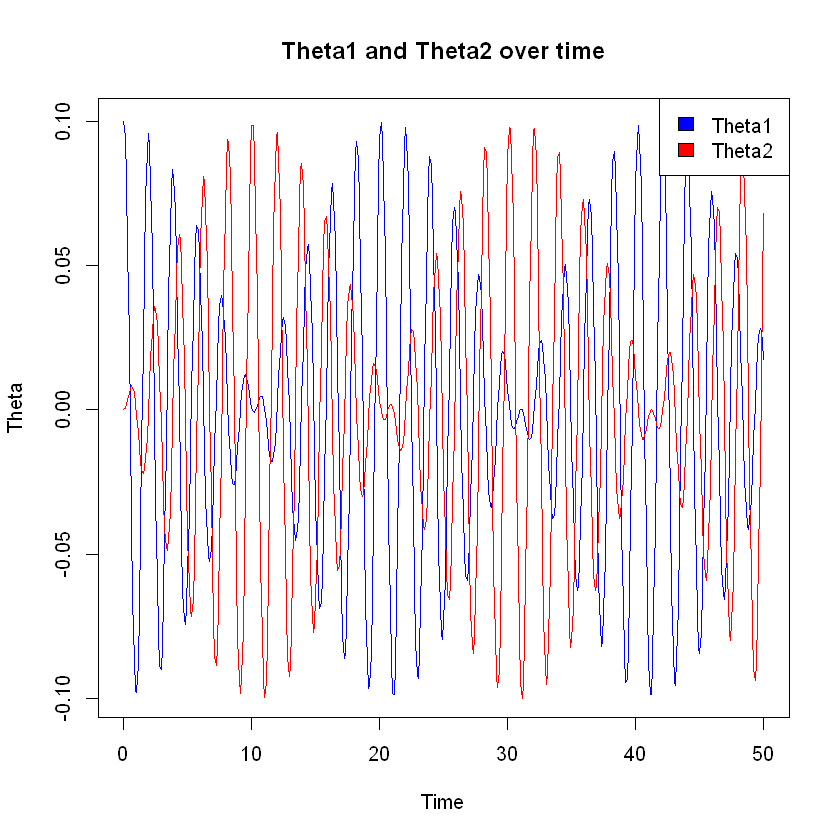

In [30]:
times <- seq(0, 50, by = .1)
init <- c(theta1 = 0.1, theta1_dot = 0, theta2 = 0, theta2_dot = 0)
parameters <- c(g = 9.81, L1 = 1, L2 = 1, k = 1)

new_coupled_osc_model_ode <- function(t, state, parameters){
  with(as.list(c(state, parameters)), {
    theta1_dot <- theta1_dot  # velocity of pendulum 1
    theta2_dot <- theta2_dot  # velocity of pendulum 2
    theta1_dot_dot <- -g/L1*sin(theta1) - k*(sin(theta1) - sin(theta2))  # acceleration of pendulum 1
    theta2_dot_dot <- -g/L2*sin(theta2) + k*(sin(theta1) - sin(theta2))  # acceleration of pendulum 2
    return(list(c(theta1_dot, theta1_dot_dot, theta2_dot, theta2_dot_dot)))
  })
}


out <- ode(y = init, times = times, func = new_coupled_osc_model_ode, parms = parameters)
out <- as.data.frame(out)

plot(out$time, out$theta1, type = "l", ylab = "Theta", xlab = "Time", col = "blue", main = "Theta1 and Theta2 over time")
lines(out$time, out$theta2, col = "red")
legend("topright", legend = c("Theta1", "Theta2"), fill = c("blue", "red"))

## fMRI Data

### Voxel A & B data

In [7]:
vox.A.B.data <- read.delim("data/voxel_A&B_data.txt",sep="",header=F)
# make column-wise
vox.A.B.data <- t(vox.A.B.data)
# dataset detailed information
head(vox.A.B.data)
tail(vox.A.B.data)
summary(vox.A.B.data)
str(vox.A.B.data)
dim(vox.A.B.data)
any(is.na(vox.A.B.data))

V1,1,7.057240,13.737100
V2,2,3.121250,-0.487973
V3,3,-4.141200,-3.683790
V4,4,-3.447630,-7.403800
V5,5,-6.535120,-6.581960
V6,6,-0.370715,-0.649483


V171,171,1.554730,3.878930
V172,172,-2.433060,-2.583420
V173,173,-2.426990,0.163615
V174,174,0.231892,0.418588
V175,175,-4.237570,-7.944550
V176,176,-2.242630,-8.954150


       V1               V2                  V3            
 Min.   :  1.00   Min.   :-6.994400   Min.   :-18.632700  
 1st Qu.: 44.75   1st Qu.:-2.439630   1st Qu.: -2.587655  
 Median : 88.50   Median : 0.250787   Median :  0.158006  
 Mean   : 88.50   Mean   : 0.000047   Mean   :  0.000012  
 3rd Qu.:132.25   3rd Qu.: 2.266418   3rd Qu.:  3.301390  
 Max.   :176.00   Max.   : 9.206440   Max.   : 13.737100  

 num [1:176, 1:3] 1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:176] "V1" "V2" "V3" "V4" ...
  ..$ : NULL


[1] 176   3

[1] FALSE

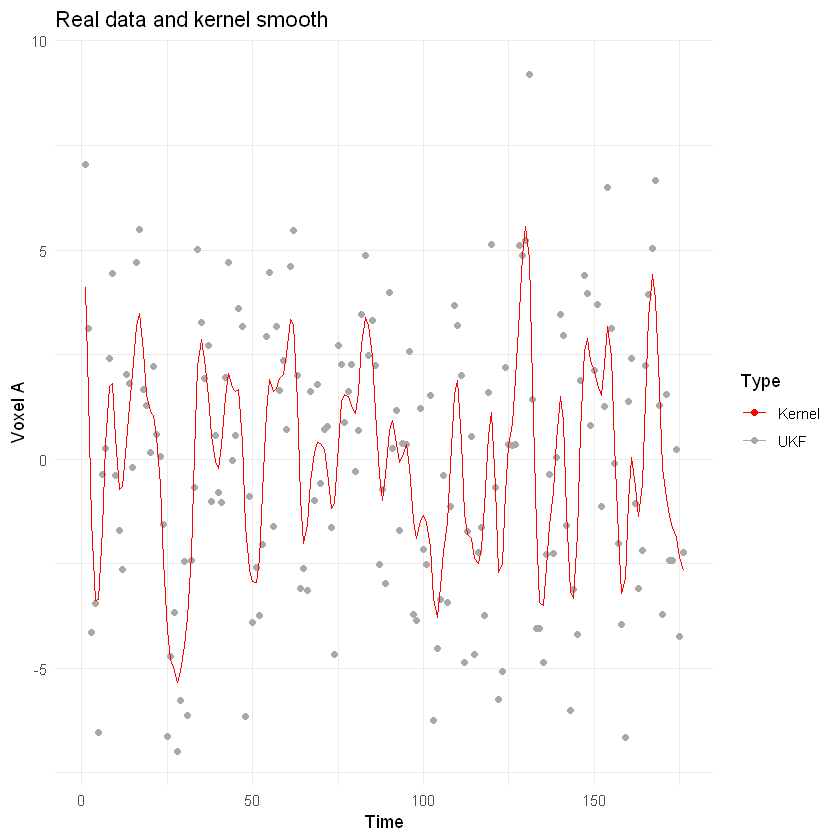

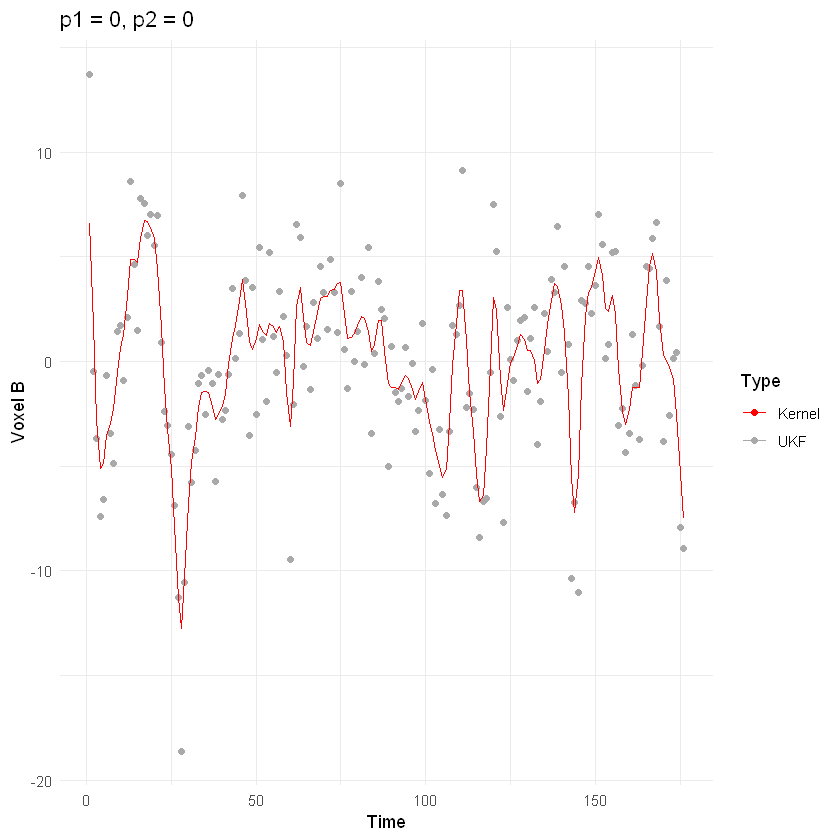

In [8]:
smoothed_data <- plot_voxels_and_smooth_ggplot(vox.A.B.data)

### Harvard-Oxford atlas dataset

In [9]:
# Read the ASD Subject 01 dataset and extract the voxel data for 18 (Left Amygdala) and 26th (Left Accumbens) voxels
subj1 <- read.csv("data/ASD Subject 01.csv")
vox.7.subj1 <- subj1[,7] # 18
vox.8.subj1 <- subj1[,8] # 26
vox.7.subj1 <- t(t(vox.7.subj1))
vox.8.subj1 <- t(t(vox.8.subj1))
# Read the Normal Subject 01 dataset and extract the voxel data for 18 (Left Amygdala) and 26th (Left Accumbens) voxels
subj2 <- read.csv("data/Normal Subject 01.csv")
vox.7.subj2 <- subj2[,7] # 18
vox.8.subj2 <- subj2[,8] # 26
vox.7.subj2 <- t(t(vox.7.subj2))
vox.8.subj2 <- t(t(vox.8.subj2))
# Combine columns and time vector
vox.A.B.subj1 <- cbind(vox.A.B.data[,1], vox.7.subj1, vox.8.subj1)
vox.A.B.subj2 <- cbind(vox.A.B.data[,1], vox.7.subj2, vox.8.subj2)

head(vox.A.B.subj1)
tail(vox.A.B.subj1)
summary(vox.A.B.subj1)
str(vox.A.B.subj1)
dim(vox.A.B.subj1)
any(is.na(vox.A.B.subj1))

V1,1,0.185279,-0.347977
V2,2,-14.079380,-9.304756
V3,3,-37.029255,-29.836547
V4,4,-51.036145,-48.679035
V5,5,-41.889142,-48.170429
V6,6,-13.494835,-24.557034


V171,171,21.368445,20.702533
V172,172,31.831874,34.303441
V173,173,19.876111,26.062780
V174,174,-1.377022,-0.388206
V175,175,-13.722065,-25.986996
V176,176,-10.960727,-33.361027


       V1               V2                 V3          
 Min.   :  1.00   Min.   :-78.6245   Min.   :-90.8049  
 1st Qu.: 44.75   1st Qu.:-25.1310   1st Qu.:-25.0703  
 Median : 88.50   Median : -2.6806   Median :  1.3674  
 Mean   : 88.50   Mean   : -0.2229   Mean   : -0.5627  
 3rd Qu.:132.25   3rd Qu.: 22.6957   3rd Qu.: 21.9033  
 Max.   :176.00   Max.   : 84.3060   Max.   : 83.9494  

 num [1:176, 1:3] 1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:176] "V1" "V2" "V3" "V4" ...
  ..$ : NULL


[1] 176   3

[1] FALSE

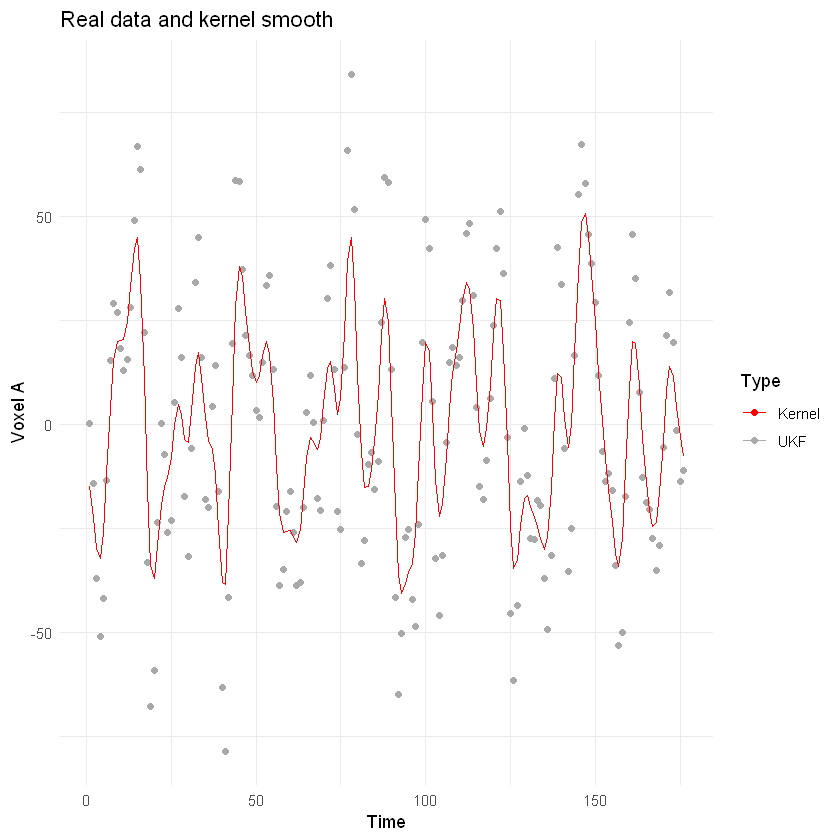

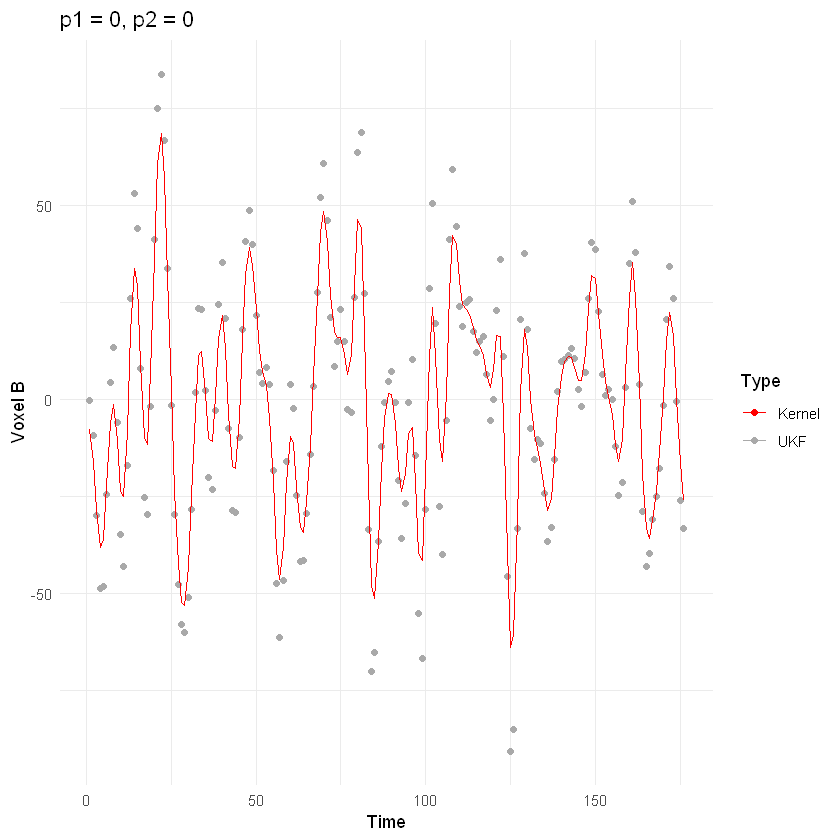

In [31]:
smoothed_subj1 <- plot_voxels_and_smooth_ggplot(vox.A.B.subj1)

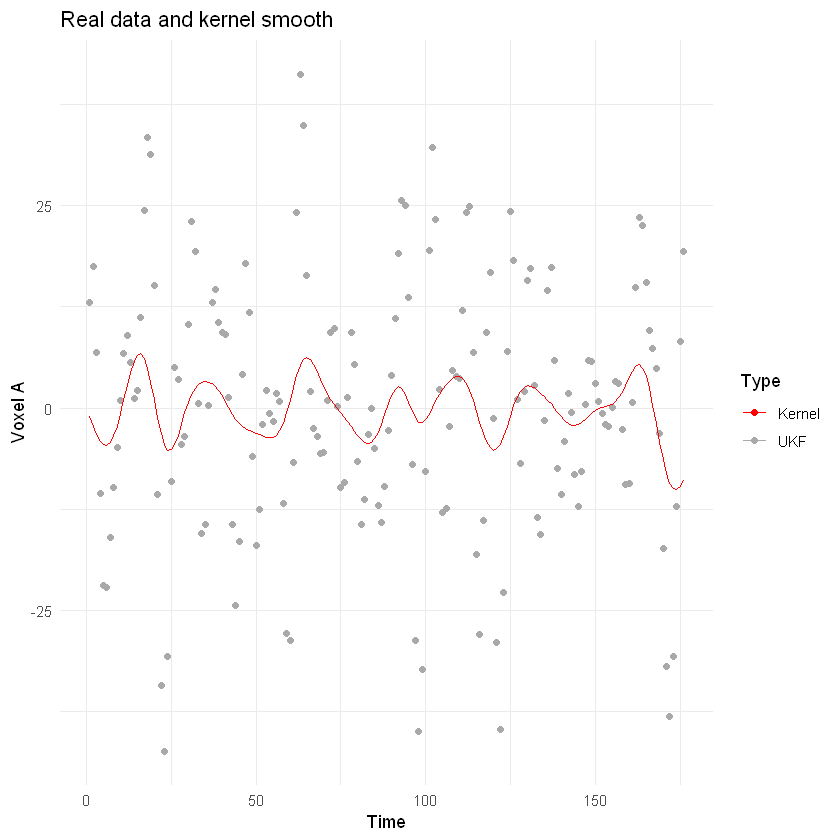

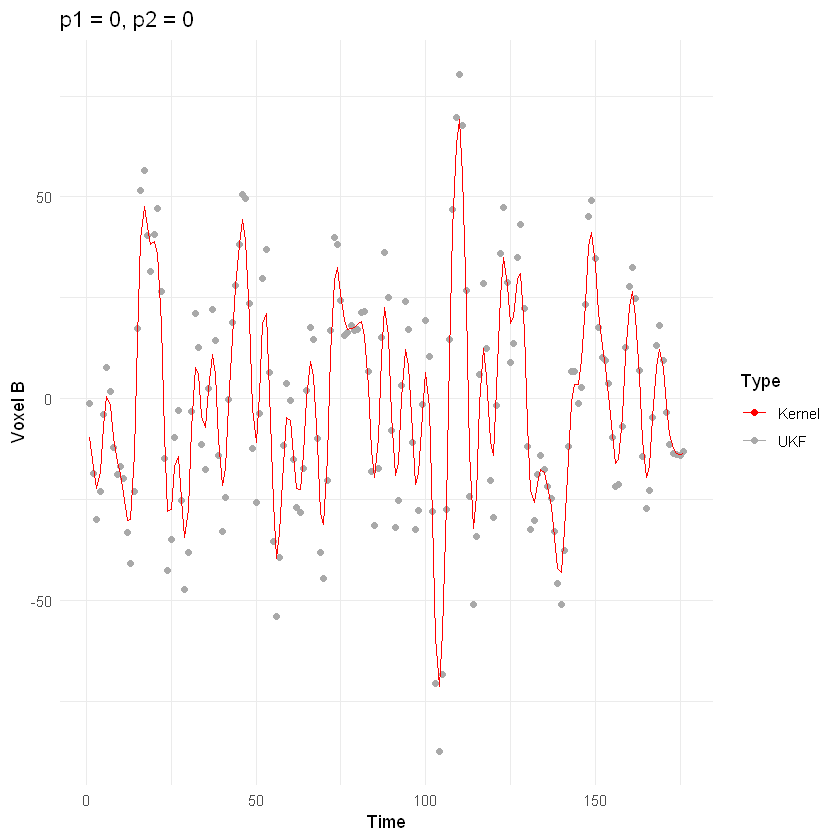

In [32]:
smoothed_subj2 <- plot_voxels_and_smooth_ggplot(vox.A.B.subj2)

Inital Parameters

In [11]:
param_guess <- c(1,1,1,4)

In [12]:
t_vec <- vox.A.B.data[,1] # time is first column
dT <- t_vec[2]-t_vec[1]   # assume uniform time steps dT=1
# smaller steps size for propagating model between dT steps
dt <- 0.1*dT
# num observed ind vars, first col is time, so -1
N_y <- ncol(vox.A.B.data)-1  # N_y=2
# number of unknown model parameters to be estimated
N_p <- 4
# size of augmented state vector
N_x <- N_p + N_y

Run UKF with new coupled oscillator model and smoothed data as input one pass through the time series

2.3615263
0.8341477
5.5160168
17.8397325


[1] 16.82988

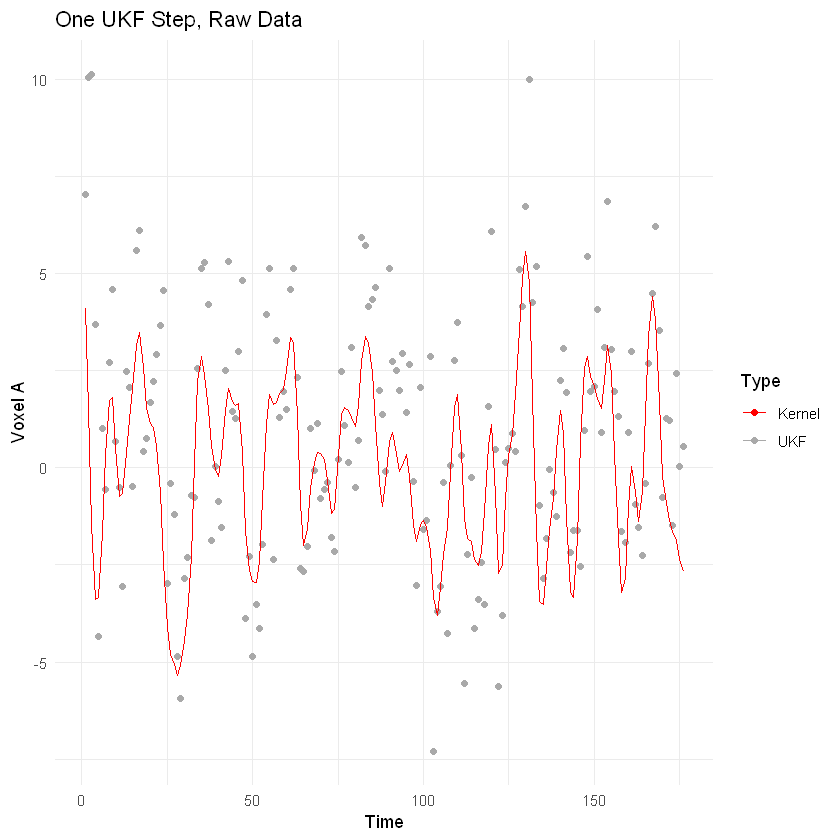

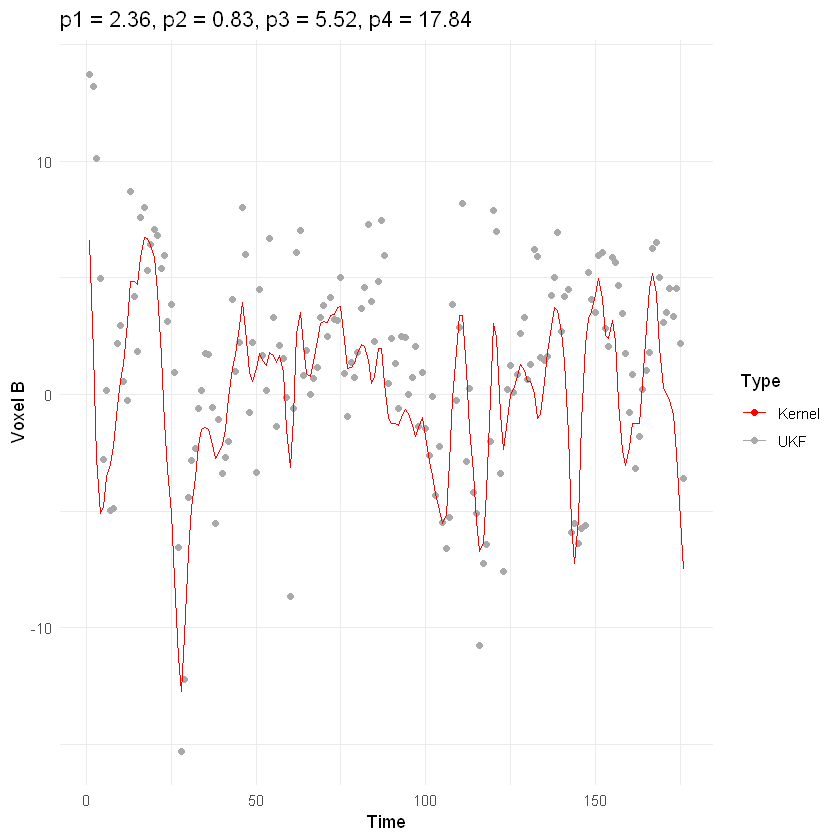

In [13]:
ukf_out <- UKF_blend(t_dummy,vox.A.B.data,new_coupled_osc_model, N_p,N_y,param_guess,dt,dT)
ukf_out$param_est
ukf_out$chisq
plot_ukf_and_smoothed_ggplot(ukf_out, smoothed_data, top_title='One UKF Step, Raw Data')

## Parameter Optimization

### Iterative Approach

7.7273939
-10.5014741
-0.1327352
-0.9536504


[1] 3.122748

[1] 100

[1] 10.86047

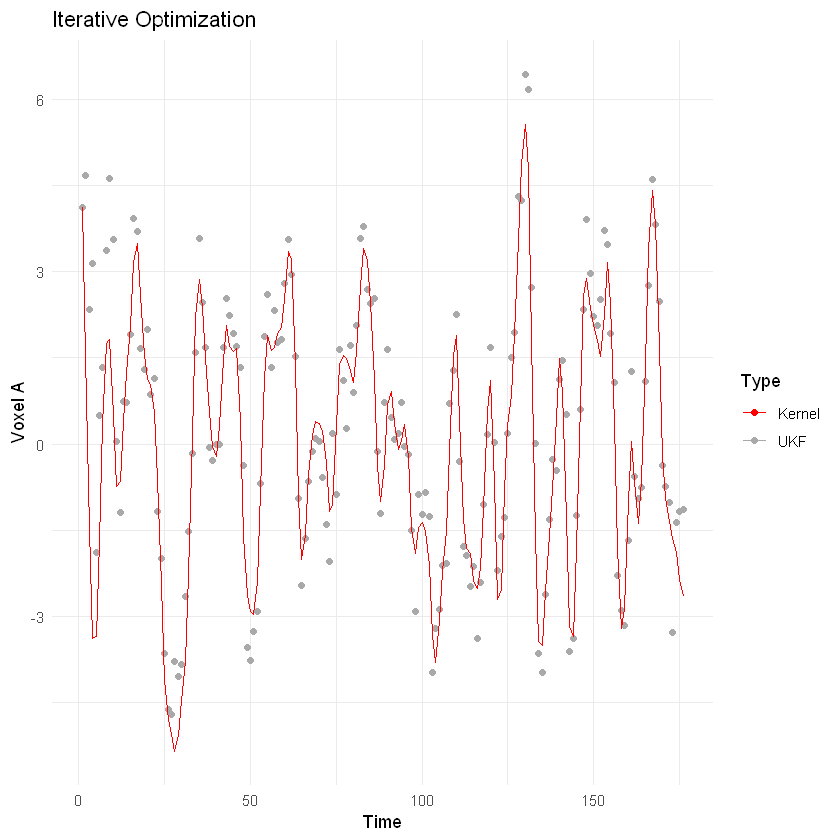

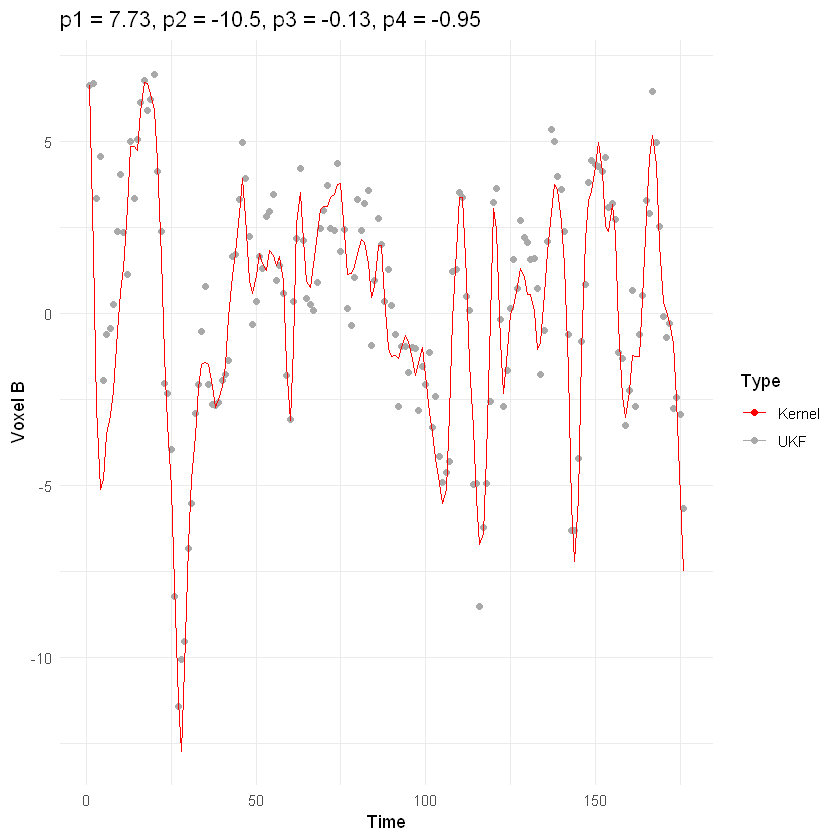

In [14]:
iter_opt <- iterative_param_optim(param_guess, t_dummy, smoothed_data, new_coupled_osc_model, N_p,N_y,dt,dT,
                      param_tol=.01,MAXSTEPS=100)
iter_opt$param_est   # params
iter_opt$value # chi-square
iter_opt$steps
iter_opt$param_norm
plot_ukf_and_smoothed_ggplot(iter_opt, smoothed_data, top_title = 'Iterative Optimization')

24.133636
-5.333192
33.200722
64.918773


[1] 286.5061

[1] 100

[1] 109.9199

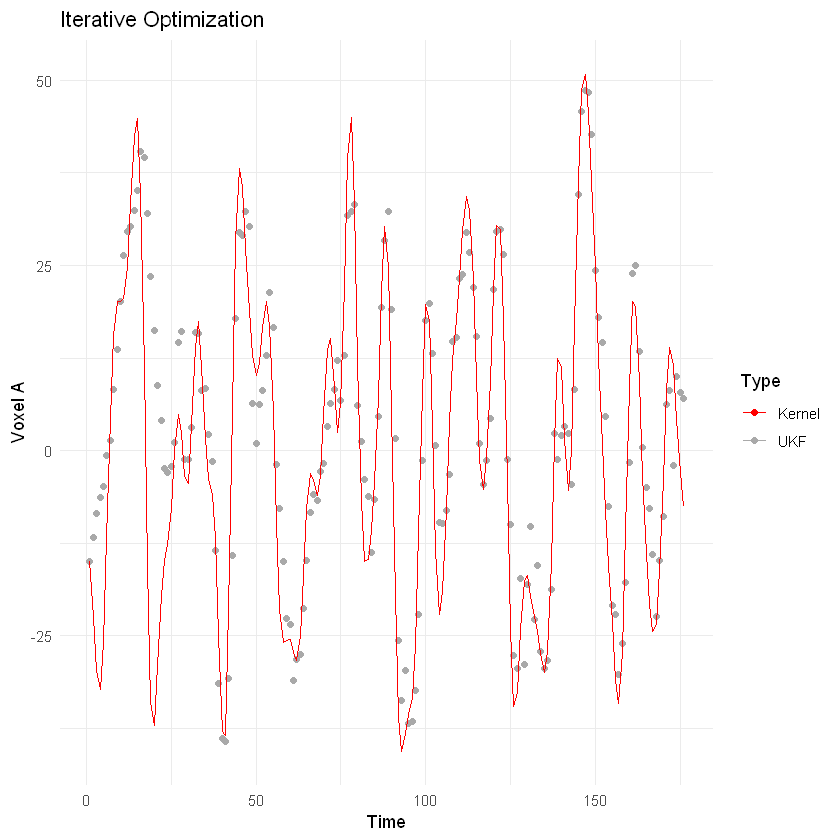

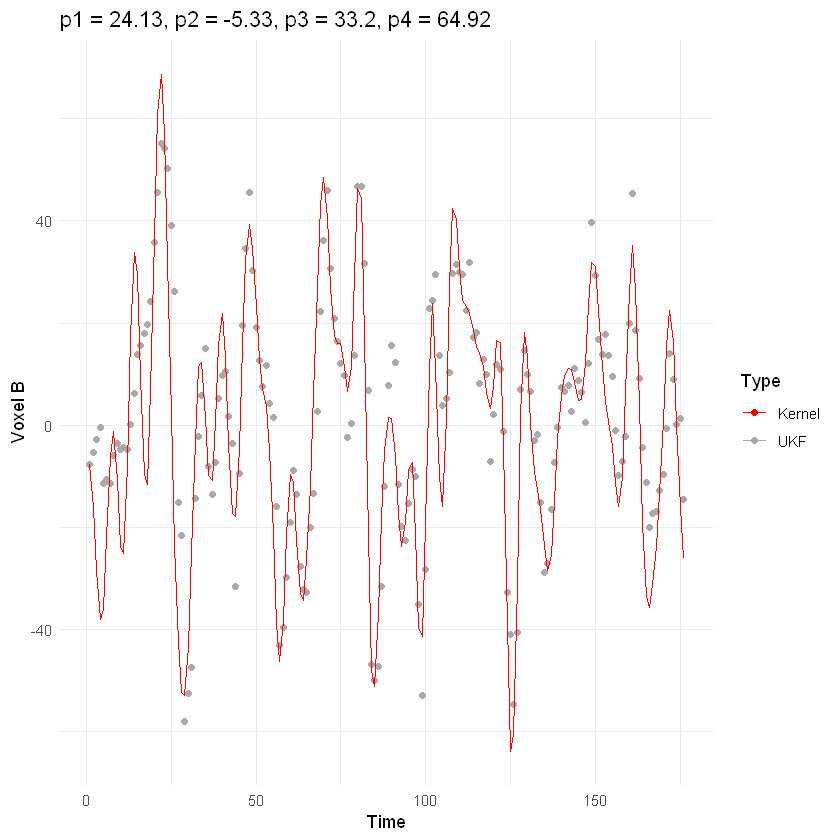

In [15]:
iter_opt <- iterative_param_optim(param_guess, t_dummy, smoothed_subj1, new_coupled_osc_model, N_p,N_y,dt,dT,
                      param_tol=.01,MAXSTEPS=100)
iter_opt$param_est   # params
iter_opt$value # chi-square
iter_opt$steps
iter_opt$param_norm
plot_ukf_and_smoothed_ggplot(iter_opt, smoothed_subj1, top_title = 'Iterative Optimization')

-27.663023
6.746365
-34.377748
20.537479


[1] 635.4572

[1] 100

[1] 41.75693

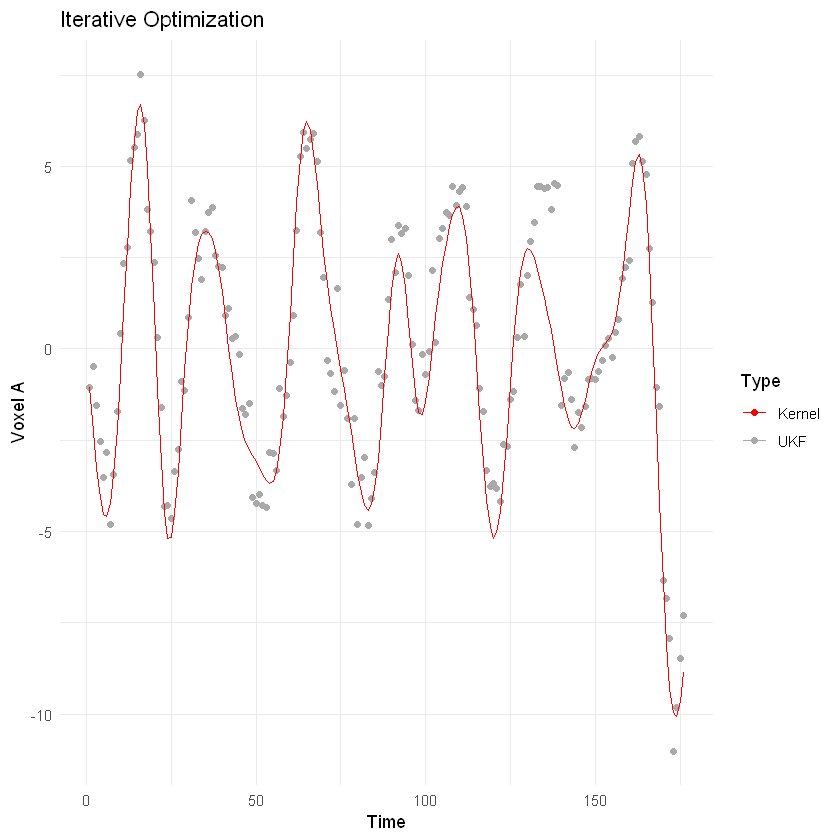

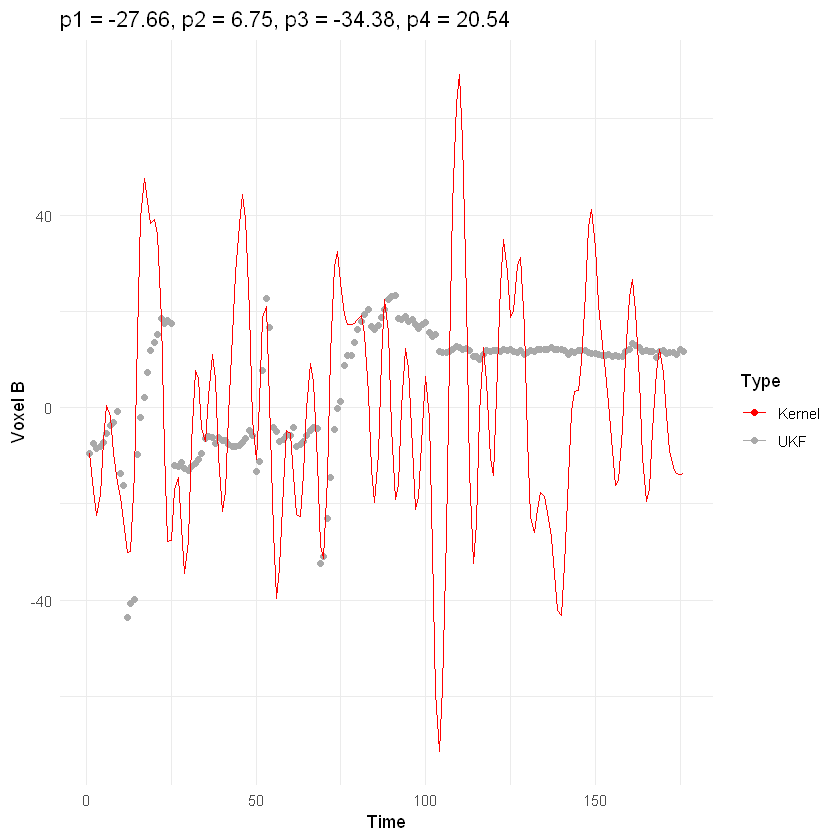

In [16]:
iter_opt <- iterative_param_optim(param_guess, t_dummy, smoothed_subj2, new_coupled_osc_model, N_p,N_y,dt,dT,
                      param_tol=.01,MAXSTEPS=100)
iter_opt$param_est   # params
iter_opt$value # chi-square
iter_opt$steps
iter_opt$param_norm
plot_ukf_and_smoothed_ggplot(iter_opt, smoothed_subj2, top_title = 'Iterative Optimization')

### Simulated Annealing

[1] -11.0877704   0.7949013  14.1446522   6.2129363

[1] 1.39565

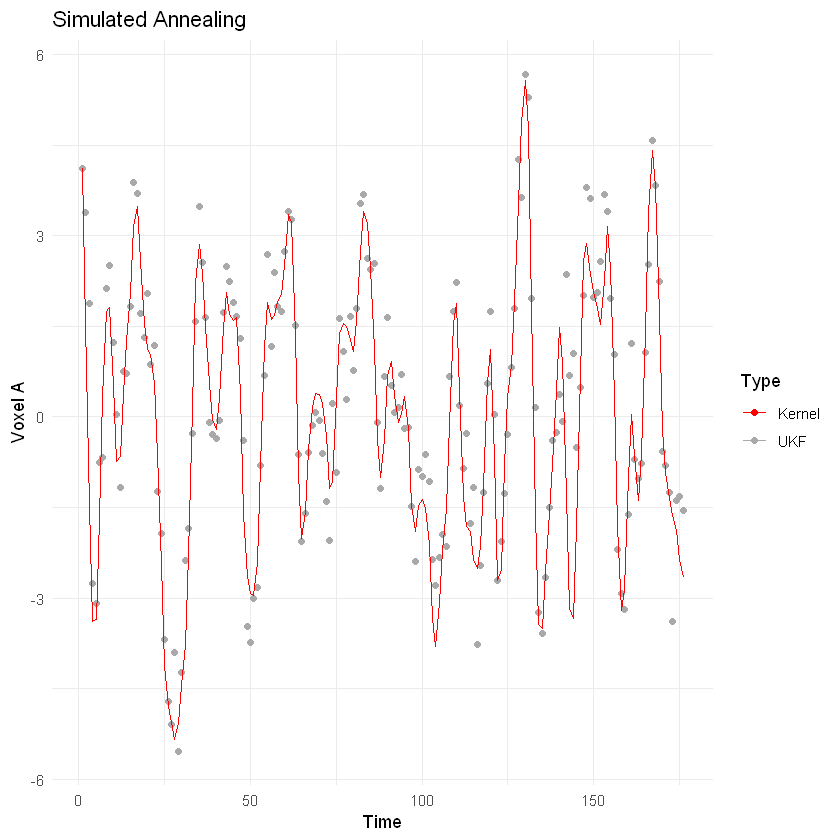

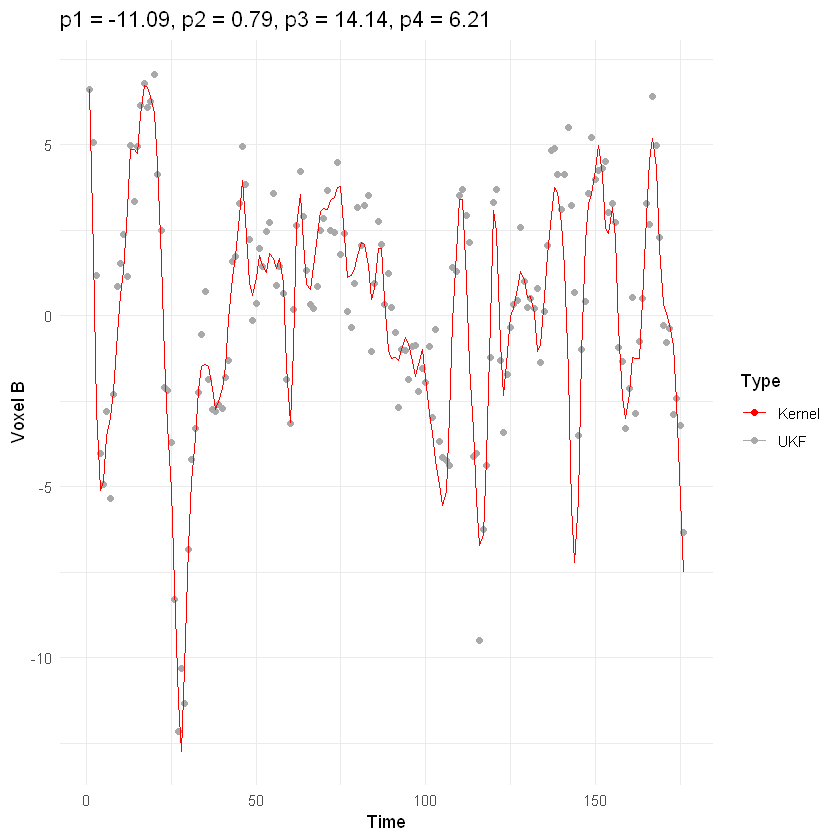

In [17]:
# Simulated Annealing with smoothed data as input
# to optimize model parameters, chisquare goodness of fit
#########################################
### Might want to make a separate UKF_blend that does not
### change the parameters because the params get changed a lot
### and yet the chisquare is the same.
### Rugged fitness landscape?
# Simulated Annealing, SANN ignores lower/upper limits
opt_sann <- optim_params(param_guess,method="SANN",lower_lim=-20,upper_lim=20,maxit=100,temp=20,
                    t_dummy,smoothed_data,new_coupled_osc_model,N_p,N_y,dt,dT)
opt_sann$param_est   # params
opt_sann$value # objective function value, chi-square
plot_ukf_and_smoothed_ggplot(opt_sann, smoothed_data, top_title = 'Simulated Annealing')

[1] 1.3799627 0.8072016 2.5778918 4.5962341

[1] 223.1288

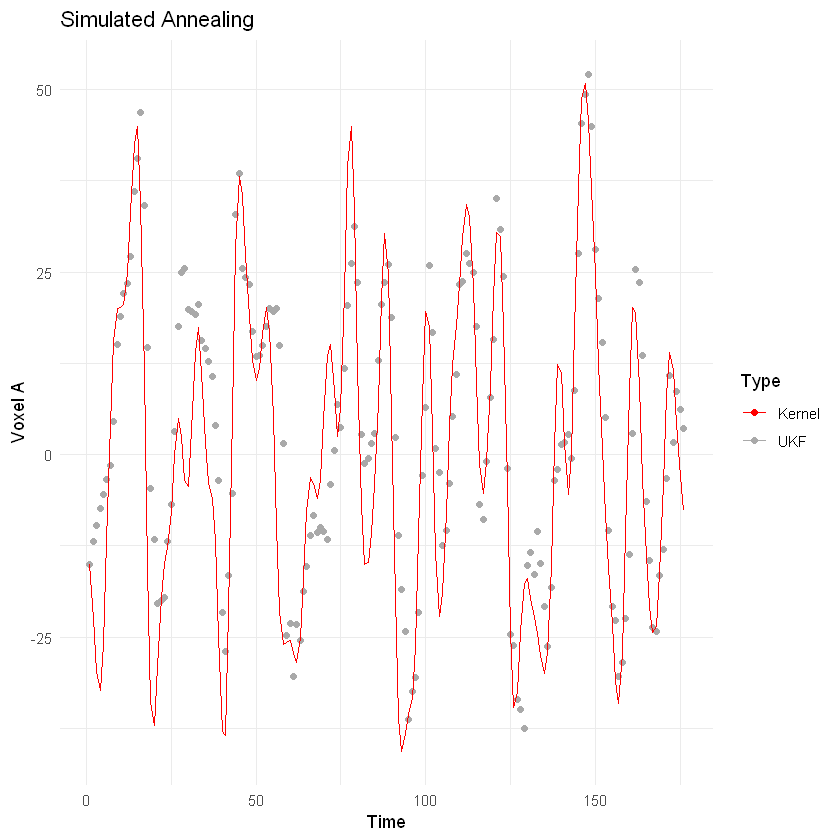

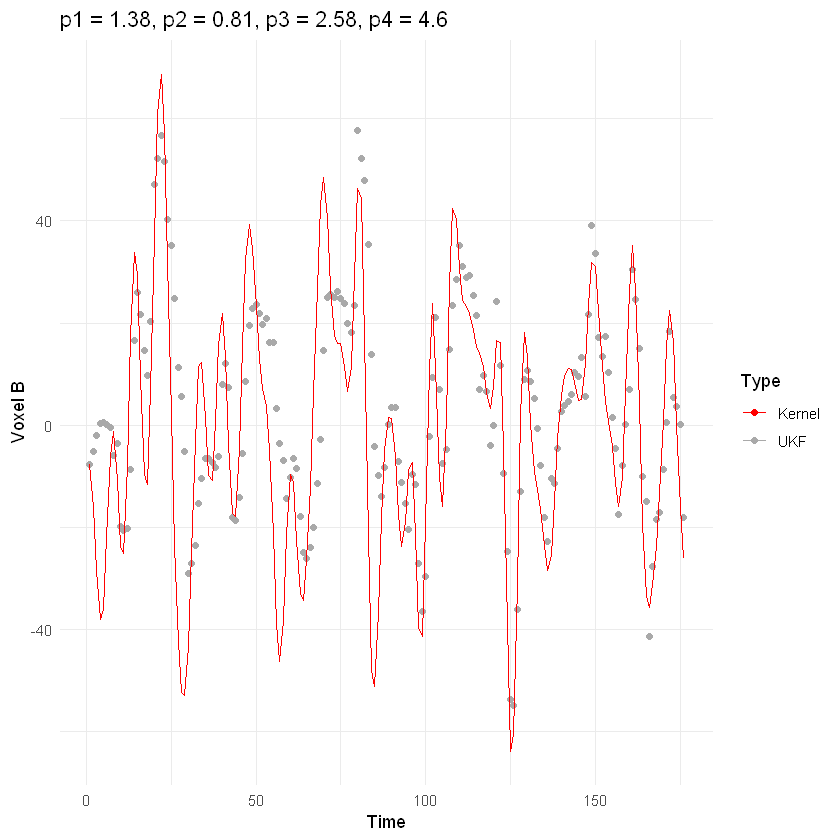

In [18]:
opt_sann_s1 <- optim_params(param_guess,method="SANN",lower_lim=-20,upper_lim=20,maxit=100,temp=20,
                    t_dummy,smoothed_subj1,new_coupled_osc_model,N_p,N_y,dt,dT)
opt_sann_s1$param_est   # params
opt_sann_s1$value # objective function value, chi-square
plot_ukf_and_smoothed_ggplot(opt_sann_s1, smoothed_subj1, top_title = 'Simulated Annealing')

[1] 1.3799627 0.8072016 2.5778918 4.5962341

[1] 275.3582

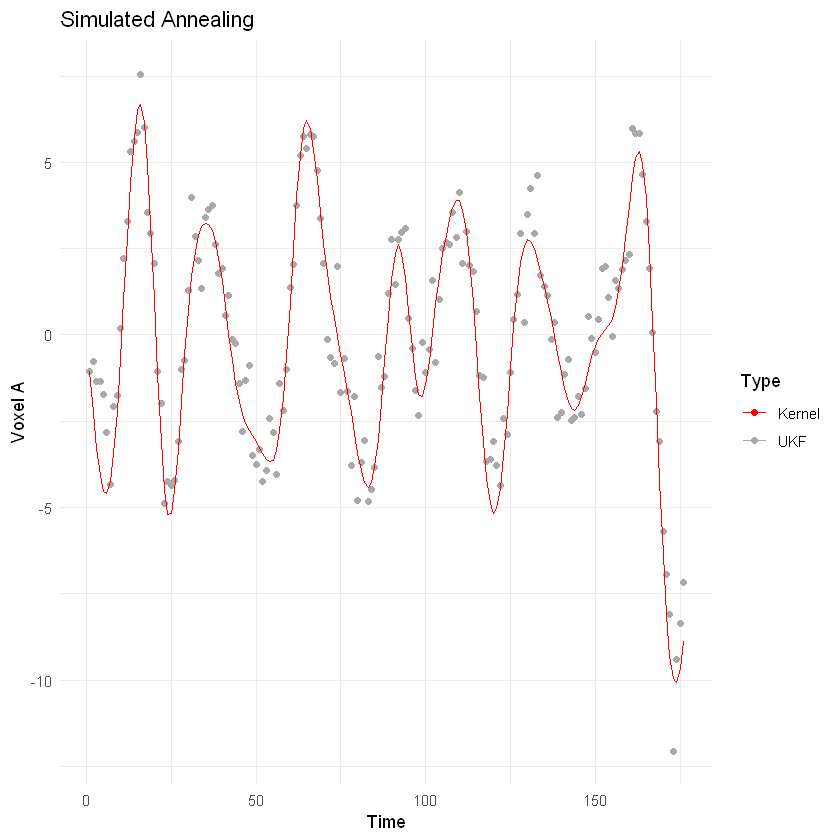

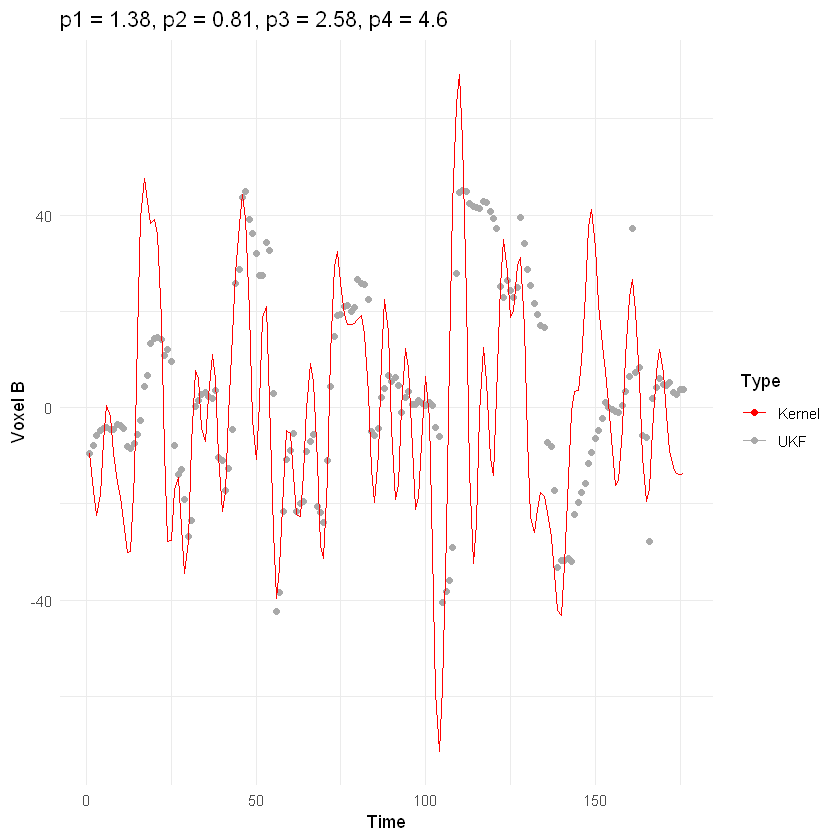

In [19]:
opt_sann_s2 <- optim_params(param_guess,method="SANN",lower_lim=-20,upper_lim=20,maxit=100,temp=20,
                    t_dummy,smoothed_subj2,new_coupled_osc_model,N_p,N_y,dt,dT)
opt_sann_s2$param_est   # params
opt_sann_s2$value # objective function value, chi-square
plot_ukf_and_smoothed_ggplot(opt_sann_s2, smoothed_subj2, top_title = 'Simulated Annealing')

### Nelder-Mead

[1] 0.9903993 1.0086863 1.0086863 4.0073148

[1] 2.245114

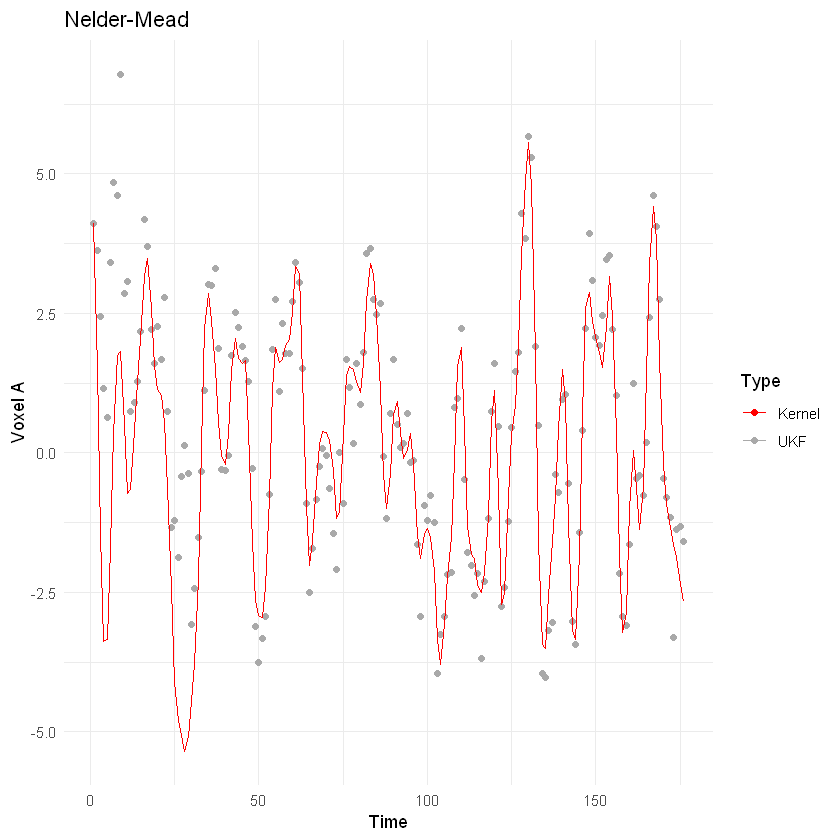

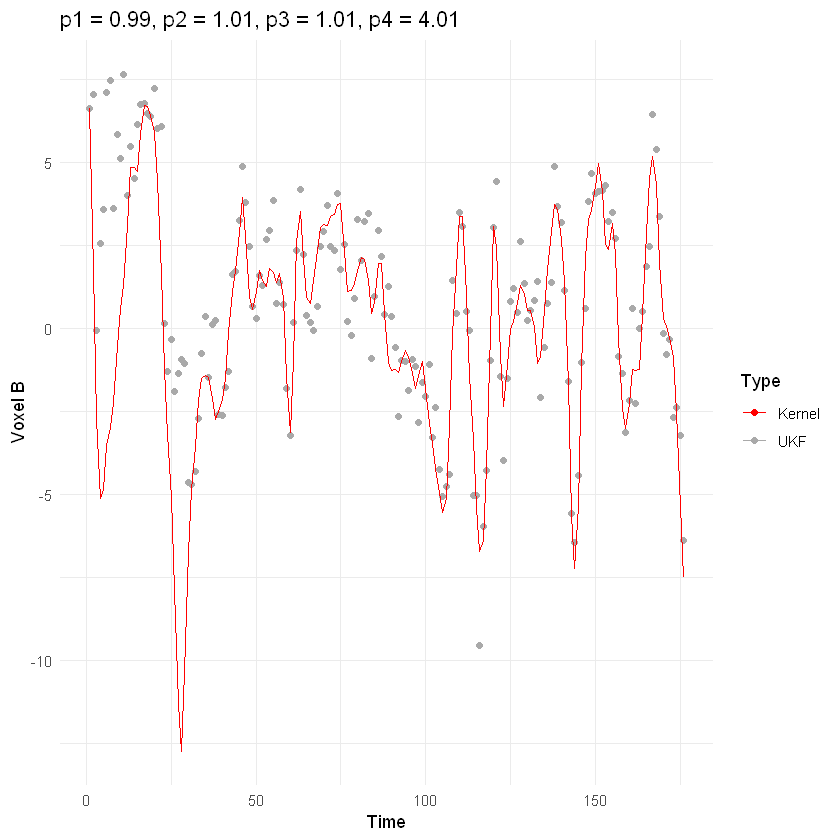

In [23]:
#########################################
# Nelder-Mead with smoothed data as input
# to optimize the parameter using UKF chisquare
#########################################
# L-BFGS-B, Nelder-Meade ignores maxit and temp
opt_nm <- optim_params(param_guess,method="Nelder-Mead",lower_lim=-20,upper_lim=20,maxit=30,temp=20,
                    t_dummy,smoothed_data,new_coupled_osc_model,N_p,N_y,dt,dT)
opt_nm$param_est   # params
opt_nm$value # objective function value, chi-square
plot_ukf_and_smoothed_ggplot(opt_nm, smoothed_data, top_title = 'Nelder-Mead')

[1] 1 1 1 4

[1] 286.5061

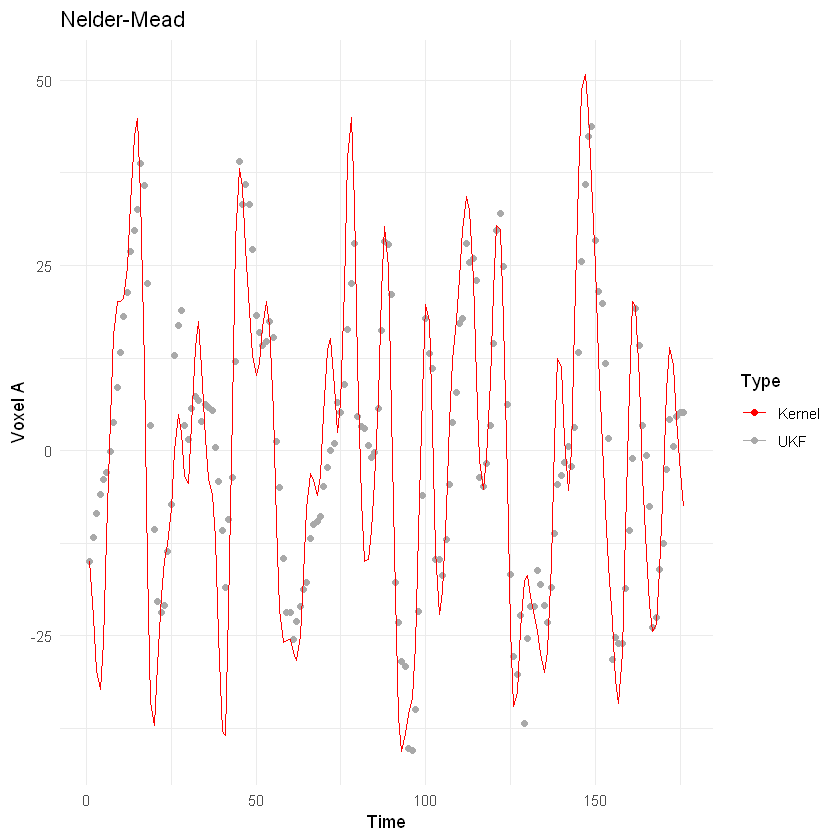

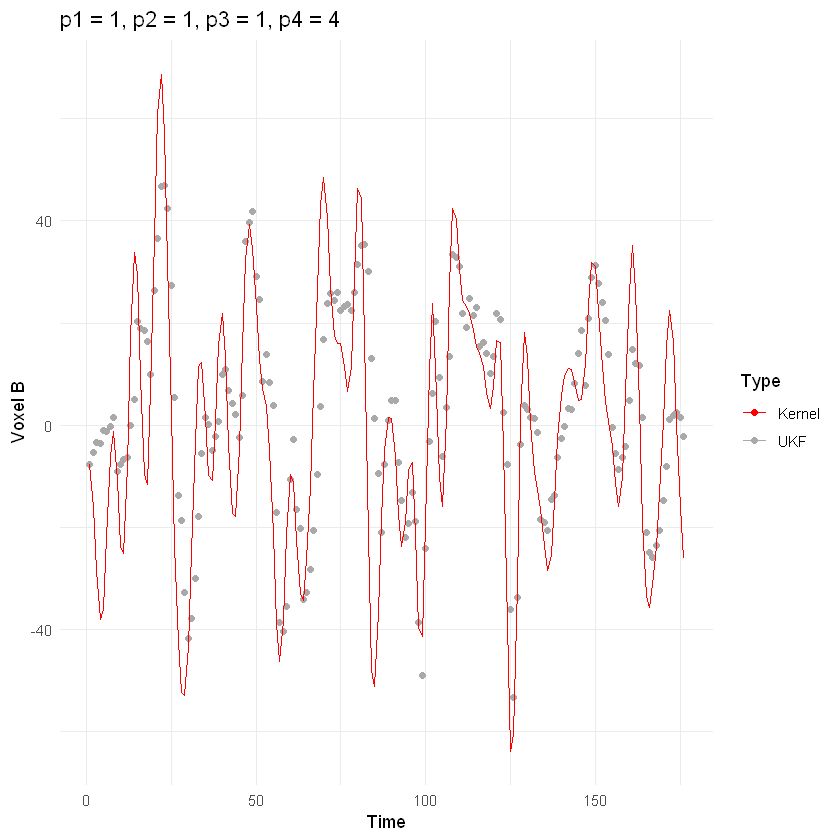

In [24]:
opt_nm_s1 <- optim_params(param_guess,method="Nelder-Mead",lower_lim=-20,upper_lim=20,maxit=30,temp=20,
                    t_dummy,smoothed_subj1,new_coupled_osc_model,N_p,N_y,dt,dT)
opt_nm_s1$param_est   # params
opt_nm_s1$value # objective function value, chi-square
plot_ukf_and_smoothed_ggplot(opt_nm_s1, smoothed_subj1, top_title = 'Nelder-Mead')

[1] 1.1576141 1.1563981 0.8272984 4.1323632

[1] 126.8841

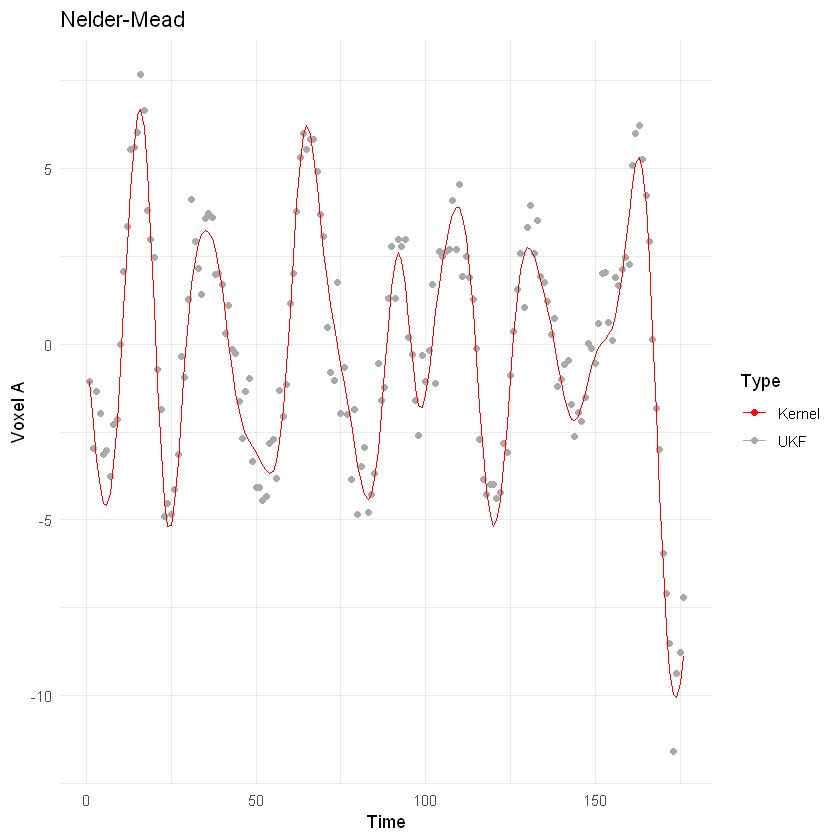

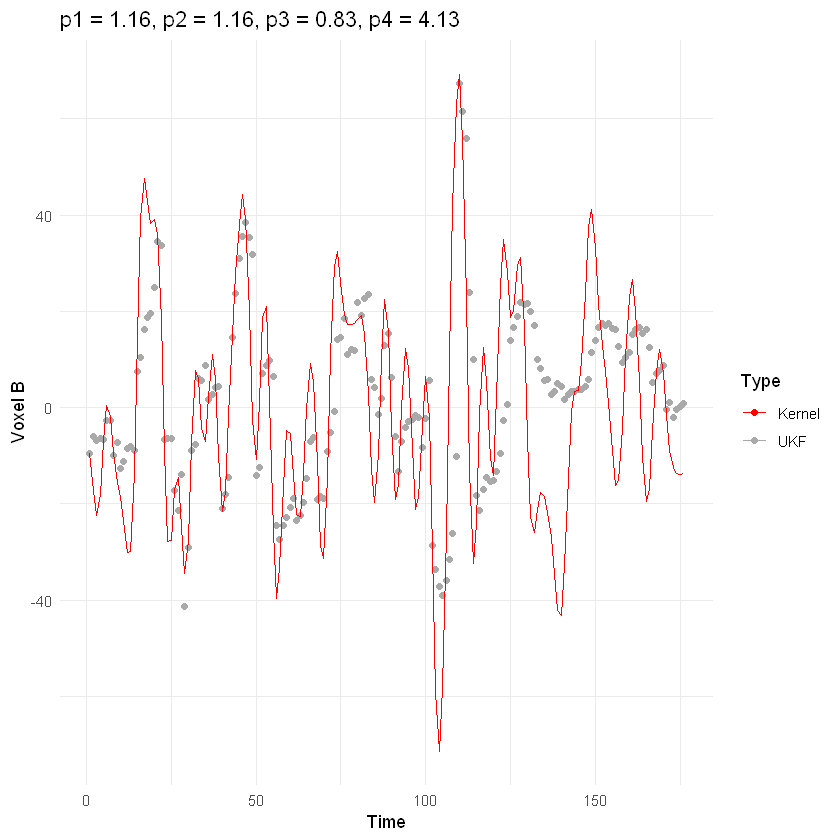

In [25]:
opt_nm_s2 <- optim_params(param_guess,method="Nelder-Mead",lower_lim=-20,upper_lim=20,maxit=30,temp=20,
                    t_dummy,smoothed_subj2,new_coupled_osc_model,N_p,N_y,dt,dT)
opt_nm_s2$param_est   # params
opt_nm_s2$value # objective function value, chi-square
plot_ukf_and_smoothed_ggplot(opt_nm_s2, smoothed_subj2, top_title = 'Nelder-Mead')

### L-BFGS-B

[1] 0.9903993 1.0086863 1.0086863 4.0073148

[1] 2.245114

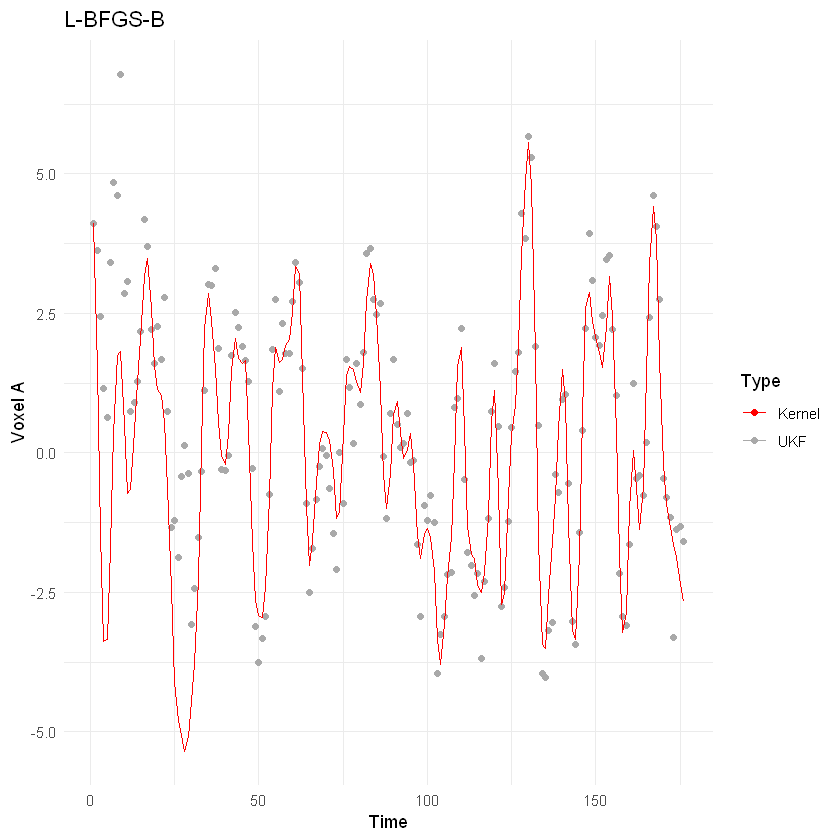

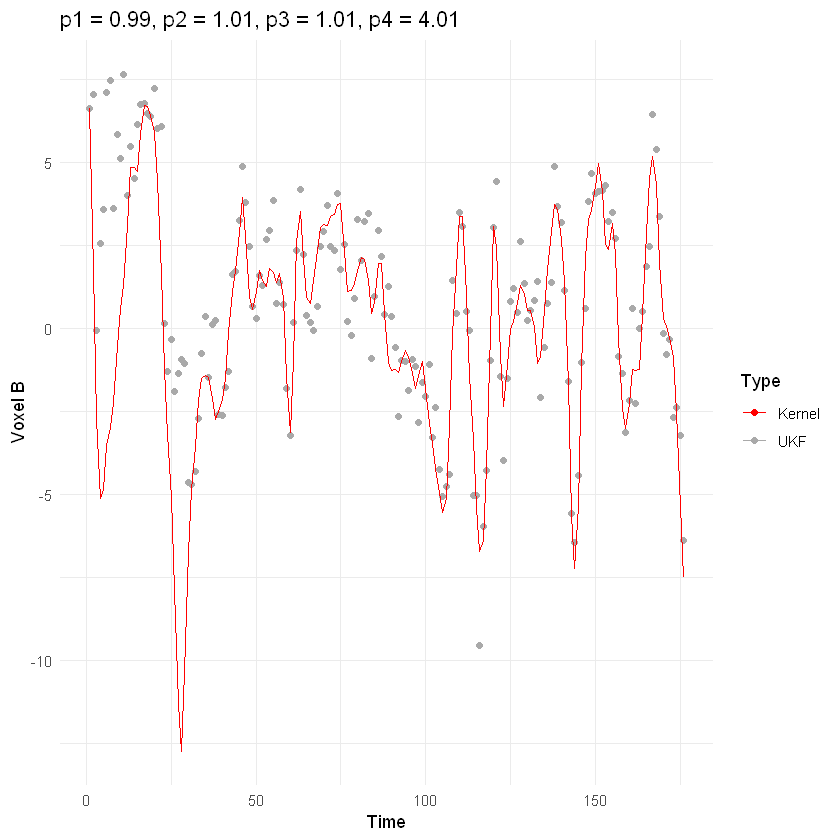

In [26]:
#########################################
# L-BFGS-B
#########################################
# L-BFGS-B, Nelder-Meade ignores maxit and temp
opt_nm <- optim_params(param_guess,method="L-BFGS-B",lower_lim=-20,upper_lim=20,maxit=30,temp=20,
                    t_dummy,smoothed_data,new_coupled_osc_model,N_p,N_y,dt,dT)
opt_nm$param_est   # params
opt_nm$value # objective function value, chi-square
plot_ukf_and_smoothed_ggplot(opt_nm, smoothed_data, top_title = 'L-BFGS-B')

[1] 1 1 1 4

[1] 286.5061

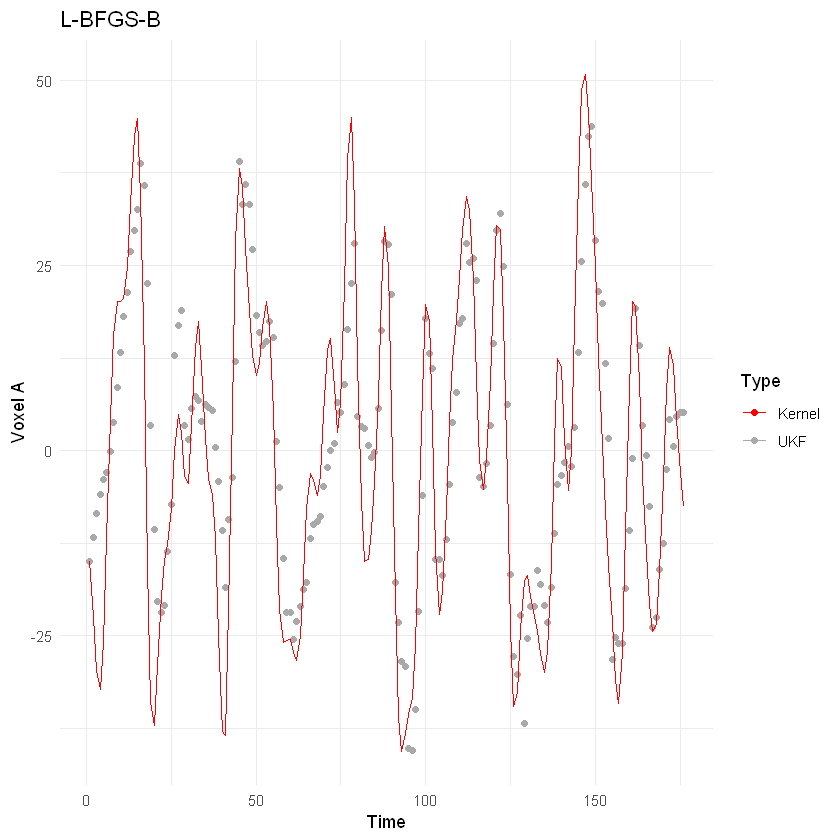

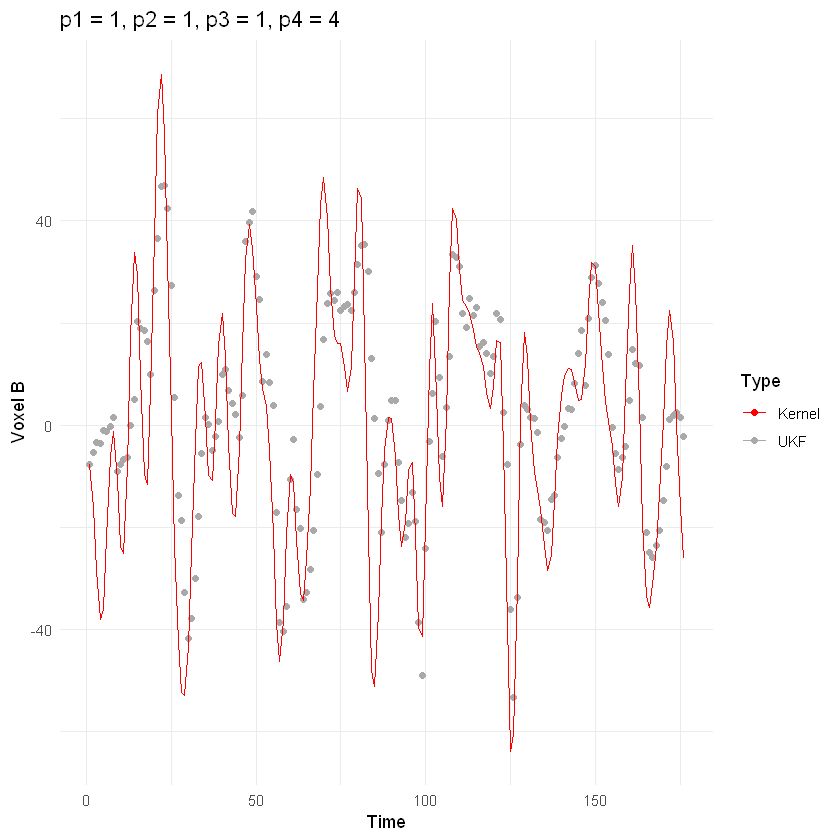

In [27]:
opt_nm_s1 <- optim_params(param_guess,method="L-BFGS-B",lower_lim=-20,upper_lim=20,maxit=30,temp=20,
                    t_dummy,smoothed_subj1,new_coupled_osc_model,N_p,N_y,dt,dT)
opt_nm_s1$param_est   # params
opt_nm_s1$value # objective function value, chi-square
plot_ukf_and_smoothed_ggplot(opt_nm_s1, smoothed_subj1, top_title = 'L-BFGS-B')

[1] 1.1576141 1.1563981 0.8272984 4.1323632

[1] 126.8841

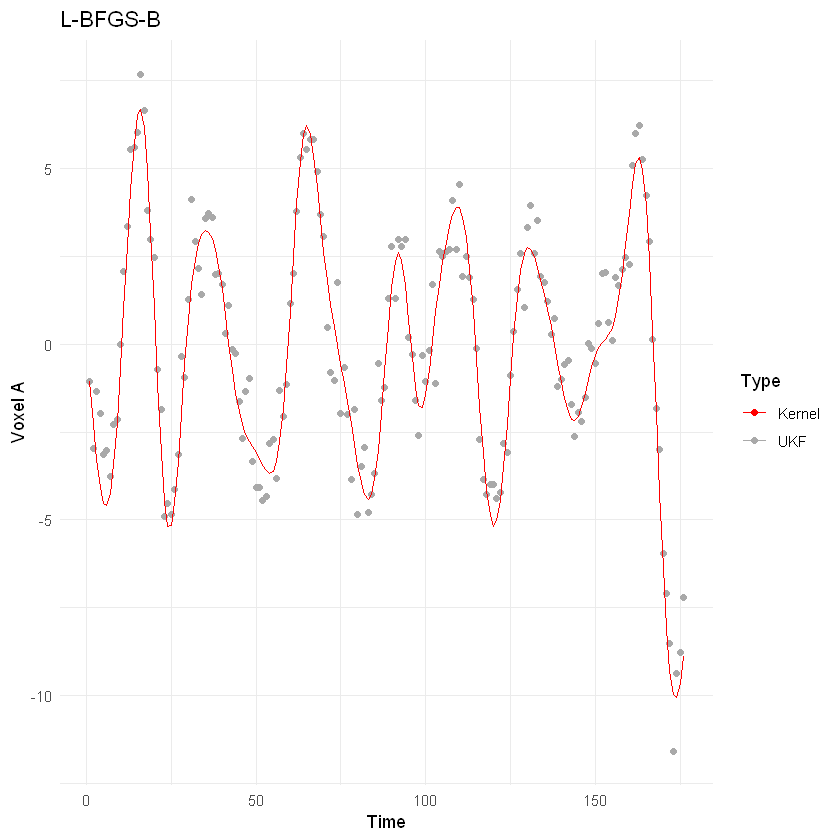

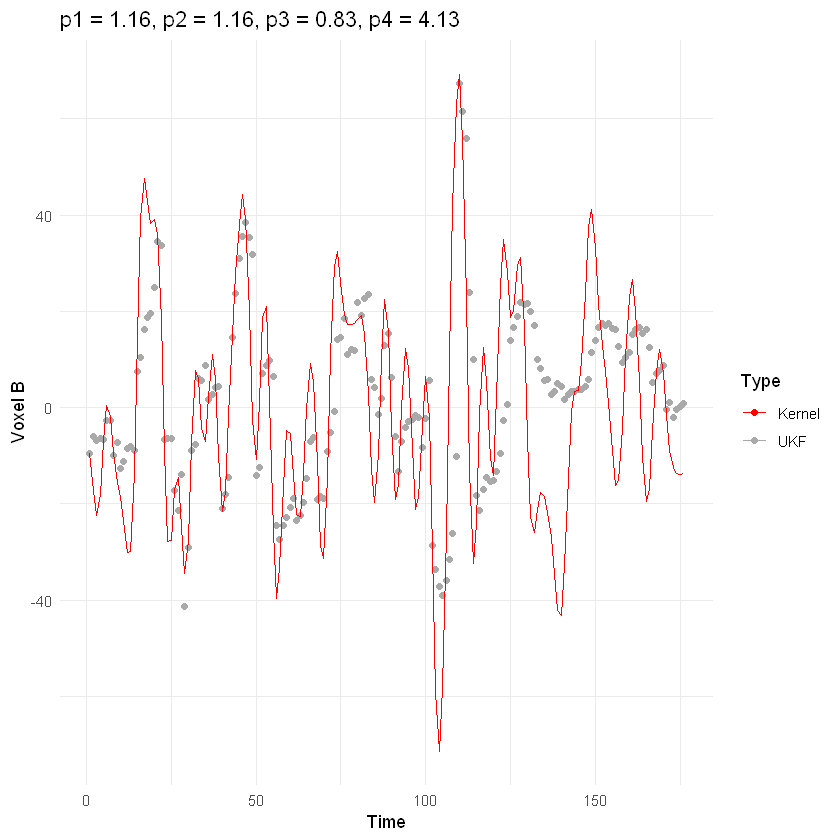

In [28]:
opt_nm_s2 <- optim_params(param_guess,method="L-BFGS-B",lower_lim=-20,upper_lim=20,maxit=30,temp=20,
                    t_dummy,smoothed_subj2,new_coupled_osc_model,N_p,N_y,dt,dT)
opt_nm_s2$param_est   # params
opt_nm_s2$value # objective function value, chi-square
plot_ukf_and_smoothed_ggplot(opt_nm_s2, smoothed_subj2, top_title = 'L-BFGS-B')